In [4]:
from scipy.io import loadmat
import numpy as np
import scipy.signal as signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math

In [5]:
def gutierrez_detector(unfiltered_ecg,fs,case):
    
    """
    Gutiérrez-rivas R, Member S, García JJ, Marnane WP, Hernández Á. 07138573. 2015;15(10):6036–43. 
    """
    #N  = round (3*fs/128)
    #Nd = N-1  
    #Pth = (0.7*fs)/128+4.7
    #Rmin = 0.26
    
    Nd = 5
    Pth = 6
    Rmin = 0.26
    
    rpeaks = []
    th = np.zeros(len(unfiltered_ecg)) #just for the visually check the threshold
    i = 1
    tf = len(unfiltered_ecg)
    Ramptotal = 0
    
    f1 = 8
    f2 = 20
    
    # Different pre-processing steps
    if case == 1:
        "Sadia 2015, R-peak detection"
        # FIR filter
        b = signal.firwin(301, [f1/250, f2/250])
        a = [1]
        filtered_ecg = signal.filtfilt(b,a,unfiltered_ecg)
        
        # Absolute Value
        abs_ecg = [abs(filtered_ecg[i]) for i in range(Nd, len(unfiltered_ecg))]

        # Integration 
        b = np.array(np.ones(Nd))
        a=[1]
        processed_ecg = signal.lfilter(b, a, abs_ecg)
                
    elif case == 2:
        # IIR butterworth
        b, a = signal.butter(1, [2*f1/fs, 2*f2/fs], btype='bandpass')
        filtered_ecg = signal.lfilter(b, a, unfiltered_ecg) 
        
        # Absolute Value
        abs_ecg = [abs(filtered_ecg[i]) for i in range(Nd, len(unfiltered_ecg))]

        # Integration 
        b = np.array(np.ones(Nd))
        a=[1]
        processed_ecg = signal.lfilter(b, a, abs_ecg)
    
    elif case == 3:
        'Sadhukan'
        # Double derivative
        diff_ecg = [unfiltered_ecg[i] - unfiltered_ecg[i - 1] for i in range(1, len(unfiltered_ecg))]
        ddiff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
            
        # Squaring
        processed_ecg = np.square(ddiff_ecg)
     
    elif case == 4:
        'Gutierrez'
        # Differentiator
        diff_ecg = [unfiltered_ecg[i] - unfiltered_ecg[i - Nd] for i in range(Nd, len(unfiltered_ecg))]

        # Integration
        b = np.array(np.ones(Nd))
        a=[1]
        int_ecg = signal.lfilter(b, a, diff_ecg)
    
        # Squaring
        processed_ecg = np.square(int_ecg)
        
        
        
    elif case == 5:
    
        'Adaptation'
        # Double derivative squared
        diff_ecg = [unfiltered_ecg[i] - unfiltered_ecg[i - Nd] for i in range(Nd, len(unfiltered_ecg))]
        ddiff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
        squar = np.square(ddiff_ecg)
        
        # Integration 
        b = np.array(np.ones(Nd))
        a=[1]
        processed_ecg = signal.lfilter(b, a, squar)
    
    
    # R-peak finder FSM
    while i < tf - fs:   # ignore last second of recording 
        
        # State 1: looking for maximum
        tf1 = round (i + Rmin*fs)
        Rpeakamp = 0
        while i < tf1:           
            # Rpeak amplitude and position 
            if processed_ecg[i] > Rpeakamp:
                Rpeakamp = processed_ecg[i]
                rpeakpos = i + 1
                th[i] = Rpeakamp
            i+=1
            th[i] = th[i-1]
            
            
        Ramptotal = (29/30)*Ramptotal + (1/30)*Rpeakamp
        rpeaks.append(rpeakpos)
        th[i] = Ramptotal
        
        
        # State 2: waiting state
        d = tf1 - rpeakpos
        tf2 = i + round(0.2*250 - d)
        while i <= tf2:
            th[i] = th[i-1]
            i+=1
           
        
        #State 3: decreasing threshold
        Thr = Ramptotal
        while processed_ecg[i] < Thr:
            Thr = Thr*math.exp(-Pth/fs)
            th[i] = Thr
            i+=1
            
    return [rpeaks, th]

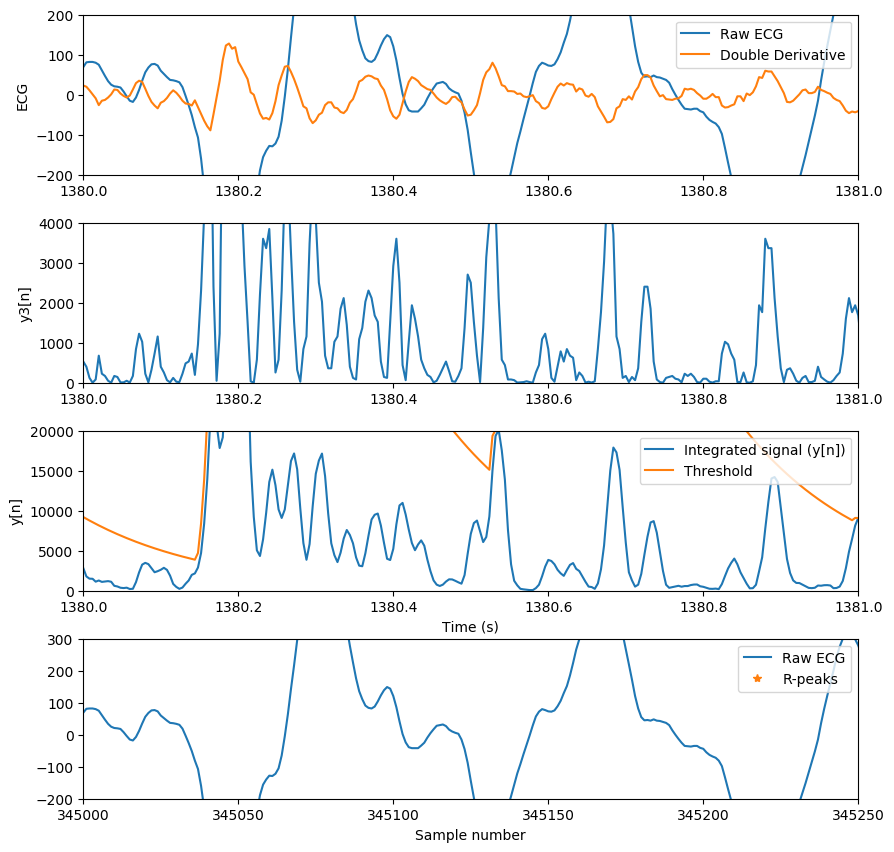

In [8]:
# Graphics and Visuals
import numpy as np
import matplotlib.pyplot as plt
#ecg_admos = np.genfromtxt("FieldWiz_Data/260320Test_NewHardware/ECG.txt",delimiter=None) 
#ecg_fieldwiz = np.genfromtxt("FieldWiz_Data/260320Test_Version2/ECG.txt",delimiter=None) 

ecg_fieldwiz = np.genfromtxt("FieldWiz_Data/20200212-LW-FWv2wet.txt",delimiter=None) 


[rpeaks, th]  = gutierrez_detector(ecg_fieldwiz,250,5)

N=6
Nd = 5
Pth = 6
Rmin = 0.26
time = np.arange(0, len(ecg_fieldwiz)/250, 1/250)
th = th[1:-5]


# Differentiator
diff_ecg = [ecg_fieldwiz[i] - ecg_fieldwiz[i - Nd] for i in range(Nd, len(ecg_fieldwiz))]
diff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
time_diff = time[5:-1]

# Abs
abs_ecg = np.square(diff_ecg)

# Integration
b = np.array(np.ones(Nd))
a=[1]
int_ecg = signal.lfilter(b, a, abs_ecg)



ti = 1380
tf = 1381
plt.figure(figsize=(10, 8), dpi=100);

plt.subplot(4,1,1)
plt.plot(time,ecg_fieldwiz)
plt.plot(time_diff,diff_ecg)
plt.xlim((ti, tf));
plt.ylim((-200, 200));
plt.ylabel('ECG')
plt.legend(['Raw ECG','Double Derivative'],loc='upper right')


plt.subplot(4,1,2)
plt.plot(time_diff,abs_ecg)
plt.xlim((ti, tf));
plt.ylim((0, 4000));
plt.ylabel('y3[n]')

plt.subplot(4,1,3)
plt.plot(time_diff,int_ecg)
plt.plot(time_diff,th)
plt.xlim((ti, tf));
plt.ylim((0, 20000));
matplotlib.pyplot.subplots_adjust(left=None, bottom=-0.1, right=None, top=None, wspace=None, hspace=0.3)
plt.xlabel('Time (s)')
plt.ylabel('y[n]')
plt.legend(['Integrated signal (y[n])','Threshold'],loc='upper right')


plt.subplot(4,1,4)
rpeaksamp = [ecg_fieldwiz[i] for i in rpeaks] 
plt.plot(ecg_fieldwiz)
plt.plot(rpeaks,rpeaksamp,'*')
plt.xlim((ti*250, tf*250));
plt.ylim((-200, 300));
plt.xlabel('Sample number')
plt.legend(['Raw ECG','R-peaks'],loc='upper right')

Text(0, 0.5, 'Heart Rate')

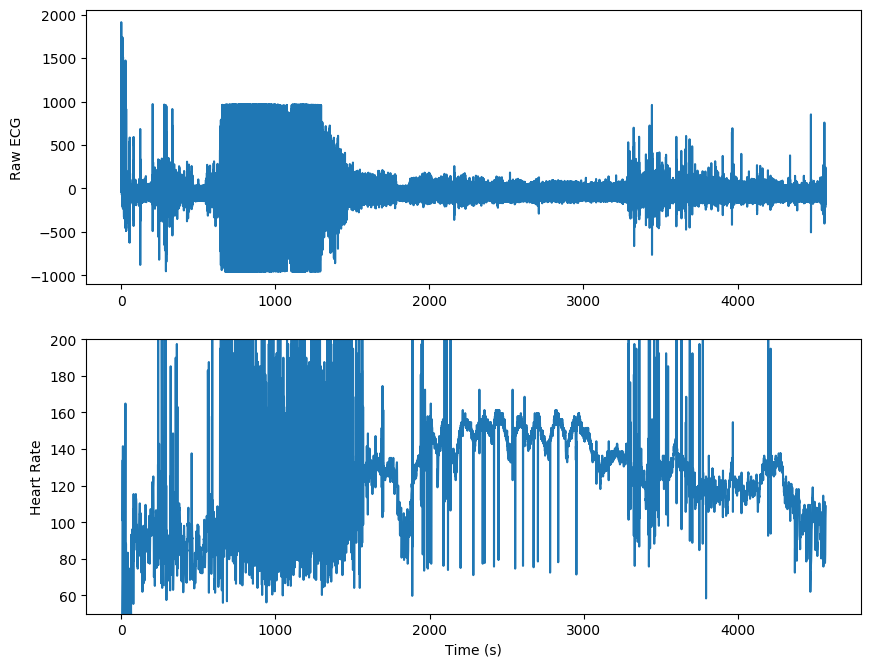

In [9]:
[rpeaks, th]  = gutierrez_detector(ecg_fieldwiz,250,5)
time = np.arange(0, len(ecg_fieldwiz)/250, 1/250)

plt.figure(figsize=(10, 8), dpi=100);

plt.subplot(2,1,1)
plt.plot(time,ecg_fieldwiz)
plt.ylabel('Raw ECG')
#plt.xlim(0,600)
rpeaks_amp = [60/(i/250) for i in np.diff(rpeaks)]
rpeaks_time = [i/250 for i in rpeaks]

plt.subplot(2,1,2)
rpeaks_time = rpeaks_time[0:-1]
plt.plot(rpeaks_time,rpeaks_amp)
plt.ylim(50,200)
#plt.xlim(0,600)

   
    
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate')